<a href="https://colab.research.google.com/github/NewCode321/ES327/blob/main/CNN_simple_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Install Dependencies and Mount Google Drive

In [102]:
# Install MediaPipe
!pip install mediapipe opencv-python

# Install Pims and AV
!pip install pims
!pip install av

# Install for confusion matrix and roc curves later
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
# Import Packages

#general
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import os.path as path # added to make organising directories easier

import glob #required for looping through files in directories

# MediaPipe Functions
mp_drawing = mp.solutions.drawing_utils #function to draw landmarks
mp_drawing_styles = mp.solutions.drawing_styles 
mp_hands = mp.solutions.hands #hand points
mp_face_mesh = mp.solutions.face_mesh #face points

# for MHIs
import scipy
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import cm #colourmaps
from mpl_toolkits.mplot3d import Axes3D 
from skimage import draw as drw
from skimage import color, img_as_float, morphology
import skimage
import pims
from IPython.display import Image

#for NN Transfer Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras import callbacks
import matplotlib.pylab as pltlab
import tensorflow_hub as hub

# for confusion matrices and roc curves
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [4]:
# mounting google drive to colab to access dataset

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# CNN trained for 3 Classes

## Load Data
- this uses mhis_joined

Tutorials 
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics 

In [104]:
# set up main data directory
import pathlib

archive = '/content/gdrive/MyDrive/mhis_joined' #main directory for the mhi dataset (train and test data together)
data_dir = pathlib.Path(archive)
data_dir

PosixPath('/content/gdrive/MyDrive/mhis_joined')

In [6]:
# packages to inspect the data
import PIL

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)# prints the number of images in the dataset

51


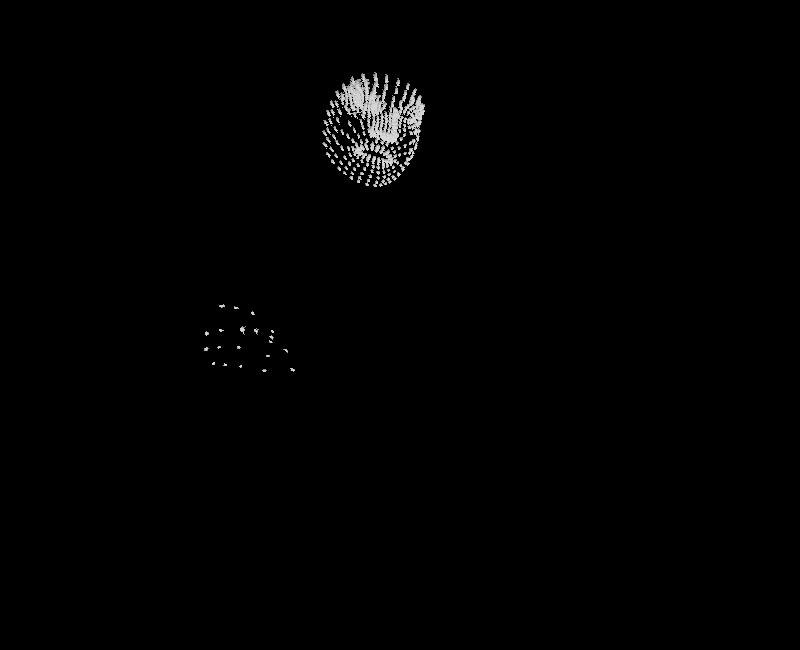

In [7]:
thinking = list(data_dir.glob('0/*'))
unsure = list(data_dir.glob('1/*'))
interested = list(data_dir.glob('2/*'))
PIL.Image.open(str(interested[1]))# can change to see different class mhis

In [120]:
IMAGE_SIZE = (299, 299)#set the image size for the model later
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4 # a smaller batch size causes the model to generalise better

data_dir = '/content/gdrive/MyDrive/mhis_joined' #main directory for the mhi dataset (train and test data together)


def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.40,#to improve increased validation 
      subset=subset,
      label_mode="categorical",
      # Seed when splitting and randomly shuffling data so that the validation set is stable across runs
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
  
# build preprocessing model
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

# data augmentation layer
do_data_augmentation = True #can make this True/False, prevents overfitting
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
  
# training dataset
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

# validation dataset
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Input size (299, 299)
Found 51 files belonging to 3 classes.
Using 31 files for training.
Found 51 files belonging to 3 classes.
Using 20 files for validation.


In [121]:
#check the classes included
print(class_names)

('0', '1', '2')


## Build the Model

In [122]:
num_classes = len(class_names)# there are three classes

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(), #comment this out to use without dropout layer
  tf.keras.layers.Dropout(0.2), # prevents overfitting
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)#output layer is tha same size as the number of classes
])

## Train the Model

In [123]:
# compile the model, include the optimiser, loss function and metrics using keras
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'), 
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ])

In [124]:
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  )


Epoch 1/10
8/8 [==============================] - 9s 937ms/step - loss: 1.1935 - accuracy: 0.4194 - auc: 0.6082 - tp: 9.0000 - fp: 15.0000 - tn: 47.0000 - fn: 22.0000 - precision: 0.3750 - recall: 0.2903 - val_loss: 1.0529 - val_accuracy: 0.5500 - val_auc: 0.6606 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 34.0000 - val_fn: 16.0000 - val_precision: 0.4000 - val_recall: 0.2000
Epoch 2/10
8/8 [==============================] - 6s 716ms/step - loss: 0.8836 - accuracy: 0.6452 - auc: 0.7851 - tp: 12.0000 - fp: 3.0000 - tn: 59.0000 - fn: 19.0000 - precision: 0.8000 - recall: 0.3871 - val_loss: 1.0830 - val_accuracy: 0.4500 - val_auc: 0.6287 - val_tp: 8.0000 - val_fp: 11.0000 - val_tn: 29.0000 - val_fn: 12.0000 - val_precision: 0.4211 - val_recall: 0.4000
Epoch 3/10
8/8 [==============================] - 6s 707ms/step - loss: 0.7665 - accuracy: 0.7419 - auc: 0.8195 - tp: 23.0000 - fp: 17.0000 - tn: 45.0000 - fn: 8.0000 - precision: 0.5750 - recall: 0.7419 - val_loss: 1.3294 - val_accuracy: 0.

In [174]:
# Create a diagram of the model architecture - uncomment to save to a filepath

#need to import the function
from keras.utils.vis_utils import plot_model

# save figure to a filepath
# plot_model(model, to_file='/content/gdrive/MyDrive/figures/cnn_simple3_plot.png', show_shapes=True, show_layer_names=True)

In [110]:
# check metrics
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_precision', 'val_recall'])


## Evaluate the Model

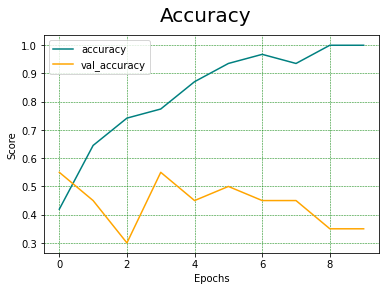

In [125]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
# plt.savefig('/content/gdrive/MyDrive/figures/trainsimple_acc_better.png')#uncomment to save
plt.show()

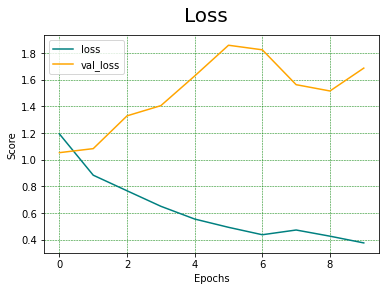

In [126]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
# plt.savefig('/content/gdrive/MyDrive/figures/trainsimple_loss_better.png')#uncomment to save
plt.show()


In [127]:
#Using the model from before, create a confusion matrix of the results on the validation dataset

# Load the test dataset
val_ds = build_dataset("validation")

# Get the predicted and true labels
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)


Found 51 files belonging to 3 classes.
Using 20 files for validation.
20/20 [==============================] - 1s 37ms/step


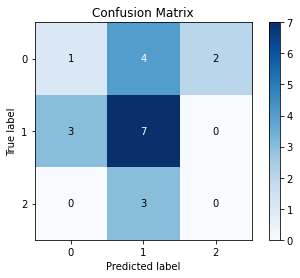

In [129]:
# plot and save the confusion matrix
cm = plot_confusion_matrix(y_true_classes, y_pred_classes)
cm
# plt.savefig('/content/gdrive/MyDrive/figures/confused.png')#uncomment to save

In [130]:
y_pred_classes

array([0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

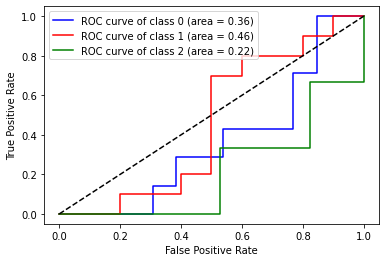

In [153]:
# plot and save the multi class ROC-AUC curve

# calculate the fp, tp, and threshold values for each class
fp = {}
tp = {}
thresholds = {}
roc_auc = {}
n_classes = len(val_ds.class_names)
for i in range(n_classes):
    fp[i], tp[i], thresholds[i] = roc_curve(y_true_classes == i, y_pred[:, i])
    roc_auc[i] = auc(fp[i], tp[i])

# plot 
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fp[i], tp[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# plt.savefig('/content/gdrive/MyDrive/figures/rocauc.png')#uncomment to save
plt.show()

# CNN trained for Binary Classification

## Load Data
- this uses mhis_joined

- source:https://www.tensorflow.org/tutorials/load_data/images

In [11]:
# set up main data directory
import pathlib

archive = '/content/gdrive/MyDrive/mhis_joined_binary' # use binary dataset
data_dir = pathlib.Path(archive)
data_dir

PosixPath('/content/gdrive/MyDrive/mhis_joined_binary')

In [12]:
import PIL

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

29


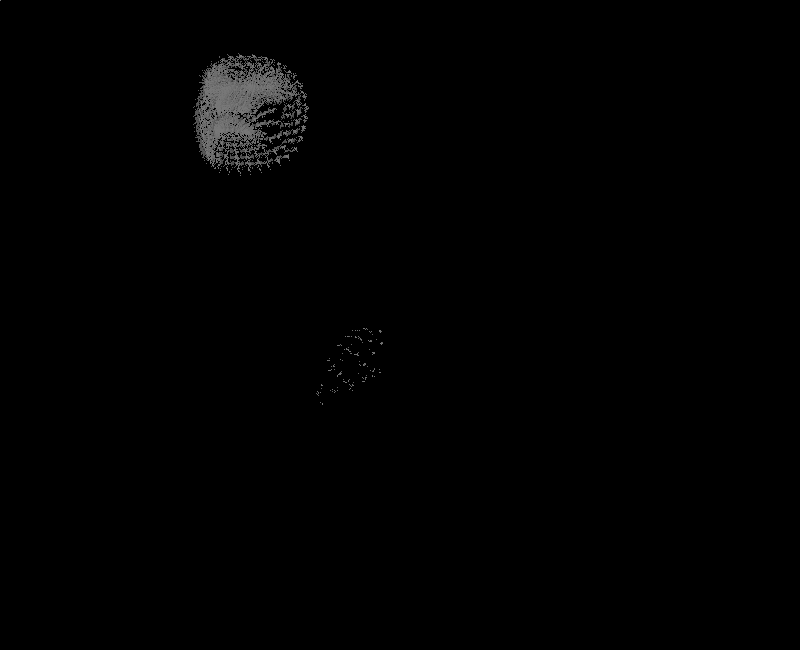

In [13]:
# display the first image in the class folder
thinking = list(data_dir.glob('0/*'))
interested = list(data_dir.glob('1/*'))
PIL.Image.open(str(thinking[1]))

In [14]:
# tutorial source:

IMAGE_SIZE = (299, 299)#set the image size for the model later
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 2 # a smaller batch size causes the model to generalise better

data_dir = '/content/gdrive/MyDrive/mhis_joined_binary' #main directory for the mhi dataset (train and test data together)


def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.40,#to improve increased validation
      subset=subset,
      label_mode="categorical",
      # Seed when splitting and randomly shuffling data so that the validation set is stable across runs
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
  
# build preprocessing model
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

# Data augmentation layer
do_data_augmentation = False #can make this True/False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))#image sizes are fixed when reading, and then a random zoom is applied
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
  
#training dataset
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

#validation dataset
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Input size (299, 299)
Found 29 files belonging to 2 classes.
Using 18 files for training.
Found 29 files belonging to 2 classes.
Using 11 files for validation.


In [15]:
#check the classes included
print(class_names)

('0', '1')


## Build the Model

In [16]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)#output layer is tha same size as the number of classes
])

## Train the Model

In [23]:

# compile the model, include the optimiser, loss function and metrics using keras
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'), 
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ])

In [25]:
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
9/9 [==============================] - 7s 657ms/step - loss: 2.9798 - accuracy: 0.8056 - auc: 0.8056 - tp: 15.0000 - fp: 4.0000 - tn: 14.0000 - fn: 3.0000 - precision: 0.7895 - recall: 0.8333 - val_loss: 2.1434 - val_accuracy: 0.8182 - val_auc: 0.8554 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 9.0000 - val_fn: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 2/10
9/9 [==============================] - 3s 352ms/step - loss: 2.9798 - accuracy: 0.8056 - auc: 0.8056 - tp: 15.0000 - fp: 4.0000 - tn: 14.0000 - fn: 3.0000 - precision: 0.7895 - recall: 0.8333 - val_loss: 2.1489 - val_accuracy: 0.8182 - val_auc: 0.8554 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 9.0000 - val_fn: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 3/10
9/9 [==============================] - 4s 459ms/step - loss: 2.9798 - accuracy: 0.8056 - auc: 0.8056 - tp: 15.0000 - fp: 4.0000 - tn: 14.0000 - fn: 3.0000 - precision: 0.7895 - recall: 0.8333 - val_loss: 2.1518 - val_accuracy: 0.8182 - v

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Evaluate the Model

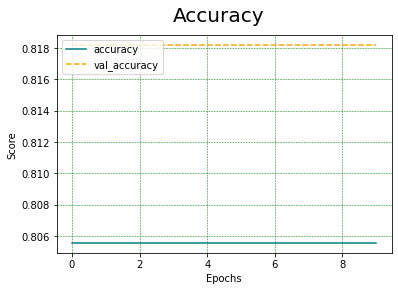

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', linestyle="--", label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.show()

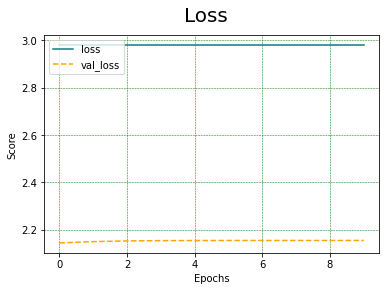

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', linestyle="--", label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.show()